<a href="https://colab.research.google.com/github/hyydrra/TimeForcasting-for-air-polution/blob/master/RNN_GRU_LSTM_TimeForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import cv2 
from google.colab.patches import cv2_imshow
from PIL import Image
import sys
import math
import random
from skimage.transform import rotate, AffineTransform
from skimage.util import random_noise
import copy


%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.models import load_model
from keras import backend as k
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [ ]:
def plot_loss(history, title):
  figure(num=None, figsize=(18, 8), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(history.history['loss'], label='Train_Data')
  plt.plot(history.history['val_loss'], label='Test_Data')
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.show()

def plot_predicted_and_real_values(real, predicted, title):
  figure(num=None, figsize=(18, 8), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(predicted)
  plt.plot(real)

  plt.xlabel('hour')
  plt.ylabel('pollution')
  plt.legend(['prediction', 'target'], loc='upper right')
  plt.title(title)
  plt.grid()
  plt.show()

# Data Prepration:

In [ ]:
data = np.load("/content/drive/My Drive/NNDL/Project2/polution_dataSet.npy")

In [ ]:
data.shape

(43799, 8)

In [ ]:
normalized_data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

In [ ]:
def make_RNN_input(dataset, window_size, target_size, step, single_step=True):
  data = []
  labels = []
  start_index = window_size
  end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-window_size, i, step)
    temp_data = []
    for index in indices:
      temp_data.append(dataset[index])
    data.append(temp_data)


    if single_step:
      labels.append(dataset[i+target_size][0])
    else:
      indices = range(i,i+target_size)
      temp_labels = []
      for index in indices:
        temp_labels.append(dataset[index][0])
      labels.append(temp_labels)

  return np.array(data), np.array(labels)



In [ ]:
train_data = normalized_data[0:12000]
# val_data = normalized_data[11000:12000]
test_data = normalized_data[12000:15000]

In [ ]:
BATCH_SIZE = 32
past_window = 11
target = 12

train_data_generator = TimeseriesGenerator(train_data, train_data[:,0:1], length=past_window, batch_size=BATCH_SIZE)
# val_data_generator = TimeseriesGenerator(val_data[:,1:], val_data[:,0:1], length=past_window)
test_data_generator = TimeseriesGenerator(test_data, test_data[:,0:1], length=past_window)

time_series_test_data, time_series_test_labels = make_RNN_input(test_data, past_window, target, 1, True)

In [ ]:
time_series_test_data.shape

(2977, 11, 8)

# Define model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU
  
def build_model():
  model = Sequential()
  model.add(GRU(32, input_shape=time_series_test_data.shape[1:]))
  # model.add(Dropout(0.2))
  model.add(Dense(16, activation = "relu"))
  model.add(Dense(1))

  #Compilation of the model
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mse','mae'])

  return model


In [ ]:
model = build_model()

model.summary()

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_data_generator,
                    epochs = 20,
                    steps_per_epoch = len(train_data_generator),
                    validation_data = test_data_generator,
                    validation_steps = len(test_data_generator))

# Evalute and plot results:

In [ ]:
predeictions = model.predict(time_series_test_data)
#sampling every 12 hours
predicted = []
real = []
for i in range(time_series_test_data.shape[0]):
  if i%12 == 0:
    predicted.append(predeictions[i])
    real.append(time_series_test_labels[i])

In [ ]:
plot_loss(history, 'Loss for Train and Test Data')
print()
plot_predicted_and_real_values(real, predicted, 'Predicted and Real Test Data for 12th and 24th hours, Model=GRU, Loss=MAE, Optimizer=Adagrad')

In [ ]:
 model.evaluate(test_data_generator, verbose=2)

[0.005606755148619413, 0.00048373921890743077, 0.01252118032425642]

# Monthly and weekly_predictions

## weekly

firts resample data for a random hour, every 24 hoar:

In [ ]:
train_to_all_ratio = 0.8
hour = random.randint(0,23)
resampled_data = []

for i in range(normalized_data.shape[0]):
  if i%24 == 0:
    resampled_data.append(normalized_data[i + hour])
    
resampled_data = np.asanyarray(resampled_data)

train_data = resampled_data[0:round(resampled_data.shape[0]*train_to_all_ratio)]
test_data = resampled_data[round(resampled_data.shape[0]*train_to_all_ratio):]

then we do like what we did in the first part of project

In [ ]:
BATCH_SIZE = 32
past_window = 6
target = past_window + 1

train_data_generator = TimeseriesGenerator(train_data, train_data[:,0:1], length=past_window, batch_size=BATCH_SIZE)
test_data_generator = TimeseriesGenerator(test_data, test_data[:,0:1], length=past_window)

time_series_test_data, time_series_test_labels = make_RNN_input(test_data, past_window, target, 1, True)

In [ ]:
model = build_model()

model.summary()

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_data_generator,
                    epochs = 50,
                    steps_per_epoch = len(train_data_generator),
                    validation_data = test_data_generator,
                    validation_steps = len(test_data_generator))

In [ ]:
predicted = model.predict(time_series_test_data)
real = time_series_test_labels


# predeictions = model.predict(time_series_test_data)
# #sampling every 7 day
# predicted = []
# real = []
# for i in range(time_series_test_data.shape[0]):
#   if i%7 == 0:
#     predicted.append(predeictions[i])
#     real.append(time_series_test_labels[i])

plot_loss(history, 'Loss for Train and Test Data')
print()
plot_predicted_and_real_values(real, predicted, 'Predicted and Real Test Data for a specific hour in day based on last 6 days, Model=LSTM, Loss=MSE, Optimizer=RMSPROP')

## Monthly

firts resample data for a random hour for every week:

In [ ]:
train_to_all_ratio = 0.8
hour = random.randint(0,23)
day = random.randint(0,5)
resampled_data = []

for i in range(normalized_data.shape[0]):
  if i%(24*7) == 0:
    resampled_data.append(normalized_data[i + (hour*day)])
    
resampled_data = np.asanyarray(resampled_data)

train_data = resampled_data[0:round(resampled_data.shape[0]*train_to_all_ratio)]
test_data = resampled_data[round(resampled_data.shape[0]*train_to_all_ratio):]

In [ ]:
BATCH_SIZE = 32
past_window = 3
target = past_window + 1

train_data_generator = TimeseriesGenerator(train_data, train_data[:,0:1], length=past_window, batch_size=BATCH_SIZE)
test_data_generator = TimeseriesGenerator(test_data, test_data[:,0:1], length=past_window)

time_series_test_data, time_series_test_labels = make_RNN_input(test_data, past_window, target, 1, True)

In [ ]:
model = build_model()

model.summary()

history = model.fit(train_data_generator,
                    epochs = 20,
                    steps_per_epoch = len(train_data_generator),
                    validation_data = test_data_generator,
                    validation_steps = len(test_data_generator))

In [ ]:
predicted = model.predict(time_series_test_data)
real = time_series_test_labels

plot_loss(history, 'Loss for Train and Test Data')
print()
plot_predicted_and_real_values(real, predicted, 'Predicted and Real Test Data for a specific hour in a specific day based on last 3 weeks, Model=LSTM, Loss=MSE, Optimizer=RMSPROP')

# Feature Selection

Seperate Columns of Features:

In [ ]:
Data = normalized_data[0:15000]
pollution = []
dew = []
temp = []
pressure = []
wind_dir = []
wind_spd = []
snow = []
rain = []
for i in range(len(Data)):
  pollution.append(Data[i][0])
  dew.append(Data[i][1])
  temp.append(Data[i][2])
  pressure.append(Data[i][3])
  wind_dir.append(Data[i][4])
  wind_spd.append(Data[i][5])
  snow.append(Data[i][6])
  rain.append(Data[i][7])

dataset = {'pollution': pollution, 'dew': dew, 'temp': temp, 'pressure': pressure, 'wind_dir': wind_dir, 'wind_spd': wind_spd, 'snow': snow, 'rain': rain}

pollution = np.asanyarray(pollution)
dew = np.asanyarray(dew)
temp = np.asanyarray(temp)
pressure = np.asanyarray(pressure)
wind_dir = np.asanyarray(wind_dir)
wind_spd = np.asanyarray(wind_spd)
snow = np.asanyarray(snow)
rain = np.asanyarray(rain)


 Find Correlation Between Pollution and Other Features:

In [ ]:
pollution_dew_crr = np.corrcoef(pollution, dew)
pollution_temp_crr = np.corrcoef(pollution, temp)
pollution_pressure_crr = np.corrcoef(pollution, pressure)
pollution_wind_dir_crr = np.corrcoef(pollution, wind_dir)
pollution_wind_spd_crr = np.corrcoef(pollution, wind_spd)
pollution_snow_crr = np.corrcoef(pollution, snow)
pollution_rain_crr = np.corrcoef(pollution, rain)

print("Pollution and Dew Correlation: ", pollution_dew_crr[0][1])
print("Pollution and Temp Correlation: ", pollution_temp_crr[0][1])
print("Pollution and Pressure Correlation: ", pollution_pressure_crr[0][1])
print("Pollution and Wind_dir Correlation: ", pollution_wind_dir_crr[0][1])
print("Pollution and Wind_spd Correlation: ", pollution_wind_spd_crr[0][1])
print("Pollution and Snow Correlation: ", pollution_snow_crr[0][1])
print("Pollution and Rain Correlation: ", pollution_rain_crr[0][1])


Pollution and Dew Correlation:  0.2420653340246873
Pollution and Temp Correlation:  0.04037831241040344
Pollution and Pressure Correlation:  -0.22407881146049208
Pollution and Wind_dir Correlation:  0.1969822634920185
Pollution and Wind_spd Correlation:  -0.23256639771866766
Pollution and Snow Correlation:  -0.014845371951258745
Pollution and Rain Correlation:  -0.0469990491040141


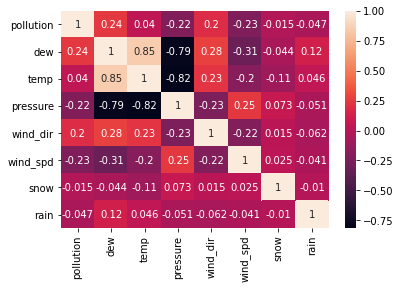

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

df = pd.DataFrame(dataset ,columns=['pollution', 'dew', 'temp', 'pressure', 'wind_dir', 'wind_spd', 'snow', 'rain'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

## Evaluate Model Using Pollution and 2 Other Best Features We Selected

Prepare New Data Using Pollution, Dew and Wind_dir features

In [ ]:
new_data = np.zeros((15000, 3), dtype=float)
for i in range(len(Data)):
  new_data[i][0] = pollution[i]
  new_data[i][1] = dew[i]
  new_data[i][2] = wind_dir[i]

In [ ]:
train_data = new_data[0:12000]
test_data = new_data[12000:15000]

In [ ]:
BATCH_SIZE = 32
past_window = 11
target = 12

train_data_generator = TimeseriesGenerator(train_data, train_data[:,0:1], length=past_window, batch_size=BATCH_SIZE)
test_data_generator = TimeseriesGenerator(test_data, test_data[:,0:1], length=past_window)
time_series_test_data, time_series_test_labels = make_RNN_input(test_data, past_window, target, 1, True)

In [ ]:
model = build_model()
model.summary()

history = model.fit(train_data_generator,
                    epochs = 20,
                    steps_per_epoch = len(train_data_generator),
                    validation_data = test_data_generator,
                    validation_steps = len(test_data_generator))

Predictions:

In [ ]:
predeictions = model.predict(time_series_test_data)
#sampling every 12 hours
predicted = []
real = []
for i in range(time_series_test_data.shape[0]):
  if i%12 == 0:
    predicted.append(predeictions[i])
    real.append(time_series_test_labels[i])

Plot Loss and Predicted values:

In [ ]:
plot_loss(history, 'Loss for Train and Test Data')
print()
plot_predicted_and_real_values(real, predicted, 'Predicted and Real Test Data for 12th and 24th hours, Model=LSTM, Loss=MSE, Optimizer=RMSprop')

# Fusion layer

prepare data

In [ ]:
train_data = normalized_data[0:12000]

test_data = normalized_data[12000:15000]

BATCH_SIZE = 32

past_window1 = 16
past_window2 = 8
past_window3 = 4


train_data_generator = TimeseriesGenerator(train_data, train_data[:,0:1], length=past_window1, batch_size=BATCH_SIZE)
test_data_generator = TimeseriesGenerator(test_data, test_data[:,0:1], length=past_window1)

In [ ]:
def fusion_input(input_data, max_window, wantedwidow):
  train_data_generator = []
  for i in range(len(input_data)):
    for j in range(len(input_data[i][0])):
      train_data_generator.append(input_data[i][0][j][max_window - wantedwidow : max_window])
  train_data_generator = np.asanyarray(train_data_generator)
  return train_data_generator


train_data1 = fusion_input(train_data_generator,past_window1,past_window1)
train_data2 = fusion_input(train_data_generator,past_window1,past_window2)
train_data3 = fusion_input(train_data_generator,past_window1,past_window3)

y= []
for i in range(len(train_data_generator)):
  for j in range(len(train_data_generator[i][0])):
    y.append(train_data_generator[i][1][j][0])


test_data1 = fusion_input(test_data_generator,past_window1,past_window1)
test_data2 = fusion_input(test_data_generator,past_window1,past_window2)
test_data3 = fusion_input(test_data_generator,past_window1,past_window3)

y_test = []
for i in range(len(test_data_generator)):
  for j in range(len(test_data_generator[i][0])):
    y_test.append(test_data_generator[i][1][j][0])

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Average, Concatenate
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import RNN

def build_model_API():
  input1 = Input(shape = train_data1[0].shape)
  input2 = Input(shape = train_data2[0].shape)
  input3 = Input(shape = train_data3[0].shape)


  hidden1_1 = LSTM(32)(input1)
  hidden1_2 = LSTM(32)(input2)
  hidden1_3 = LSTM(32)(input3)
  
  hidden2_1 = Dense(16, activation='relu')(hidden1_1)
  hidden2_2 = Dense(16, activation='relu')(hidden1_2)
  hidden2_3 = Dense(16, activation='relu')(hidden1_3)

  hidden3 = Average()([hidden2_1, hidden2_2, hidden2_3])
  output = Dense(1)(hidden3)
  model = Model(inputs=[input1, input2, input3], outputs=output)

  #Compilation of the model
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mse','mae'])

  return model

def build_model_API_2():
  input1 = Input(shape = train_data1[0].shape)
  input2 = Input(shape = train_data2[0].shape)
  input3 = Input(shape = train_data3[0].shape)


  hidden1_1 = LSTM(16)(input1)
  hidden1_2 = LSTM(8)(input2)
  hidden1_3 = LSTM(4)(input3)
  
  hidden2_1 = Dense(16, activation='relu')(hidden1_1)
  hidden2_2 = Dense(16, activation='relu')(hidden1_2)
  hidden2_3 = Dense(16, activation='relu')(hidden1_3)
  
  hidden3 = Concatenate()([hidden2_1, hidden2_2, hidden2_3])
  hidden4 = Dense(8, activation='relu')(hidden3)
  output = Dense(1)(hidden4)
  model = Model(inputs=[input1, input2, input3], outputs=output)

  #Compilation of the model
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mse','mae'])

  return model

In [ ]:
model = build_model_API_2()

model.summary()

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([train_data1, train_data2, train_data3], np.asanyarray(y), epochs=20 ,validation_data = ([test_data1, test_data2, test_data3], np.asarray(y_test)))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 16, 8)        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 8, 8)         0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 4, 8)         0                                            
__________________________________________________________________________________________________
lstm_18 (LSTM)                  (None, 16)           1600        input_19[0][0]                   
____________________________________________________________________________________________

In [ ]:
predeictions = model.predict([test_data1, test_data2, test_data3])
#sampling every 12 hours
predicted = []
real = []
for i in range(test_data1.shape[0]):
  if i%12 == 0:
    predicted.append(predeictions[i])
    real.append(y_test[i])

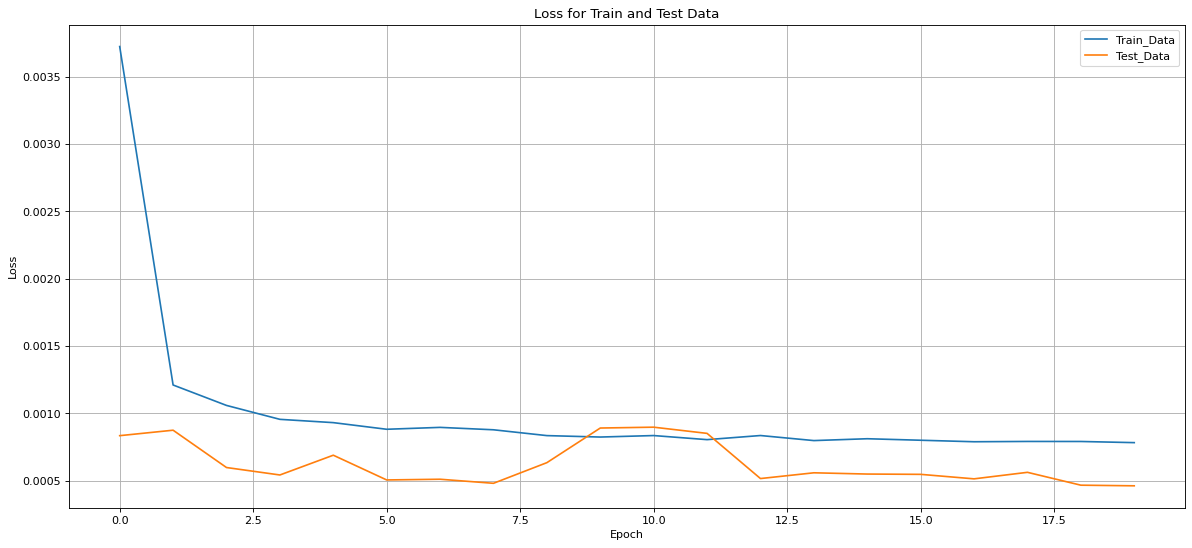

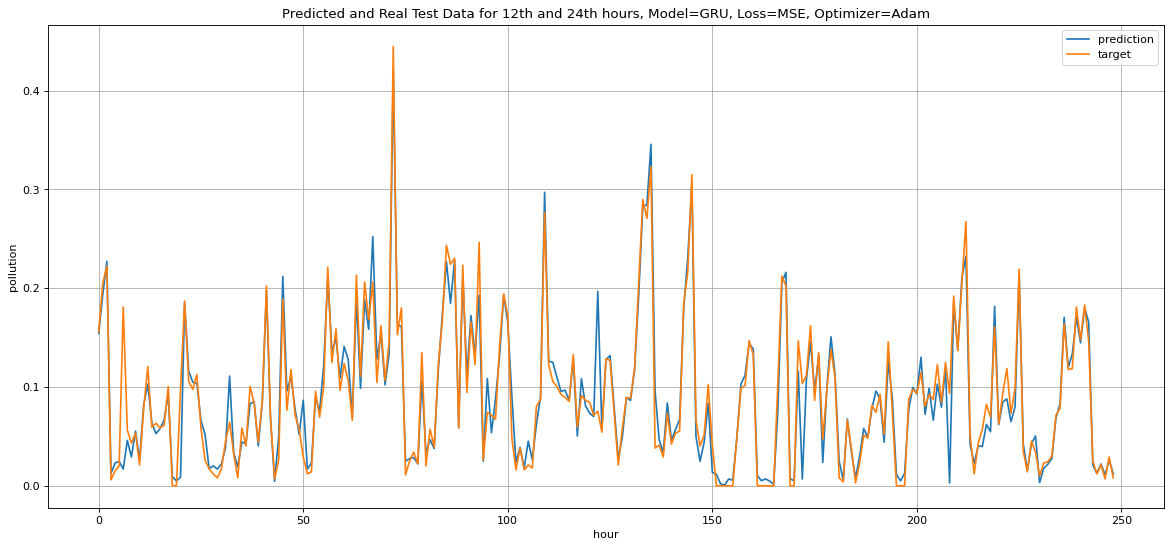

In [ ]:
plot_loss(history, 'Loss for Train and Test Data')
print()
plot_predicted_and_real_values(real, predicted, 'Predicted and Real Test Data for 12th and 24th hours, Model=GRU, Loss=MSE, Optimizer=Adam')

In [ ]:
model.evaluate([test_data1, test_data2, test_data3], np.asarray(y_test), verbose=2)

[0.0004626368340808616, 0.00046263678814284503, 0.012856250628829002]

# **PART 2: Handle missing data**

delete 20% of data

In [ ]:
def add_nan_to_dataset(data,loss_ratio):
  l = list(range(0, data.shape[0]))
  random.shuffle(l)
  random_index_of_data_to_be_nan = l[0:round(len(l)*0.2)]
  data_with_nan_values = copy.deepcopy(data)
  for index in random_index_of_data_to_be_nan:
    data_with_nan_values[index] = np.array([np.nan] * 8)
  return data_with_nan_values

In [ ]:
from scipy import interpolate
from scipy.interpolate import interp1d

def cubic_interpolation(data, len_points_for_interpolation,linear_spline):
  all_predictions = []
  for i in range(len(data)):
    if np.isnan(data[i]):
      point_counter = 0
      points_left_side = []
      points_right_side = []
      cnt = 1
      x =[]
      cant_interpolate = 0
      left_condition = 1
      right_condition = 1
      while(True):
        if ( len(points_left_side) >0 and len(points_right_side) >0 ):
          if (point_counter >= len_points_for_interpolation):
            break
        if (left_condition or right_condition or cnt < len_points_for_interpolation*10) != True:
          cant_interpolate=1
          break;

        left_condition = 0
        right_condition = 0
        if ( i-cnt >=0 and len(points_left_side) <= len_points_for_interpolation -1):
          if np.isnan(data[i-cnt]) != True:
            x.append(i-cnt)
            points_left_side.append(data[i-cnt])
            point_counter =  point_counter + 1
            left_condition =1

        if (i+cnt < len(data) and len(points_right_side) <= len_points_for_interpolation -1):
          if np.isnan(data[i+cnt]) != True:
            x.append(i+cnt)
            points_right_side.append(data[i+cnt])
            point_counter =  point_counter + 1
            right_condition = 1
        
        cnt = cnt + 1

 
      x.sort()
      x = np.asarray(x)
      x1 = x - min(x)
      y = points_left_side + points_right_side
      if (cant_interpolate):
        all_predictions.append([i,np.mean(y)])

      elif linear_spline == "linear":
        f = interp1d(x1, y, kind='cubic')
        all_predictions.append([i,f(i-min(x))])

      elif linear_spline == "spline":
        tck = interpolate.splrep(x1, y, s=0)
        all_predictions.append([i,interpolate.splev(i-min(x), tck, der=0)])
  return all_predictions


def knn(data, len_points_for_interpolation):
  all_predictions = []

  for i in range(len(data)):
    
    if np.isnan(data[i]):
      wind_direction_values = {"0.0":0, "0.33333334":0, "0.6666667":0, "1.0":0}
      point_counter = 0
      points_left_side = []
      points_right_side = []
      cnt = 1
      while(True):
        if (point_counter >= len_points_for_interpolation):
          break

        if ( i-cnt >=0 ):
          if np.isnan(data[i-cnt]) != True:
            points_left_side.append(data[i-cnt])
            point_counter =  point_counter + 1

        if (i+cnt < len(data) ):
          if np.isnan(data[i+cnt]) != True:
            points_right_side.append(data[i+cnt])
            point_counter =  point_counter + 1
        cnt = cnt + 1

 

      y = points_left_side + points_right_side
      for point in y:
        for key in wind_direction_values.keys():
          if (key == str(point)):
            wind_direction_values[key] = wind_direction_values[key] +1
      pred = 1
      max_count = 0
      for key in wind_direction_values.keys():
        if wind_direction_values[key] >= max_count:
          max_count = wind_direction_values[key]
          pred = float(key)
      all_predictions.append([i,pred])

  return all_predictions

In [ ]:
normalized_data_with_nan = add_nan_to_dataset(normalized_data,0.2)
COLOUMN_NAMES = ["Pollution", "dew", "temp", "pressure", "wind direction", "wind speed", "snow", "rain" ]

In [ ]:
i = 4
num_points_for_interpolation = 7
data_with_filled_lost_data = copy.deepcopy(normalized_data_with_nan)

real = normalized_data[:,i:i+1].reshape(1,-1)[0]
prediction = knn(normalized_data_with_nan[:,i:i+1].reshape(1,-1)[0],num_points_for_interpolation)
correct = 0
for j in range(len(prediction)):
  data_with_filled_lost_data[prediction[j][0]][i] = prediction[j][1]
  if abs(prediction[j][1]-real[prediction[j][0]]) < 0.2:
    correct = correct + 1
accuracy = correct/j
sum_ = 0
for j in range(len(prediction)):
  data_with_filled_lost_data[prediction[j][0]][i] = prediction[j][1]
  sum_ = sum_ + (prediction[j][1]-real[prediction[j][0]])**2
MSE = sum_/j


print("MSE "+COLOUMN_NAMES[i],":",MSE)
print("accuracy "+COLOUMN_NAMES[i],":",accuracy)

MSE wind direction : 0.09763327171096003
accuracy wind direction : 0.6923718215923301


In [ ]:
num_points_for_interpolation = 4
data_with_filled_lost_data = copy.deepcopy(normalized_data_with_nan)

for i in range(8):
  real = normalized_data[:,i:i+1].reshape(1,-1)[0]
  prediction = cubic_interpolation(normalized_data_with_nan[:,i:i+1].reshape(1,-1)[0],num_points_for_interpolation,"linear")
  sum_ = 0
  for j in range(len(prediction)):
    data_with_filled_lost_data[prediction[j][0]][i] = prediction[j][1]
    sum_ = sum_ + (prediction[j][1]-real[prediction[j][0]])**2
  MSE = sum_/j
  print("MSE "+COLOUMN_NAMES[i],":",MSE)

MSE Pollution : 0.0010209028373584425
MSE dew : 0.0006103846860362231
MSE temp : 0.0010318684164684797
MSE pressure : 0.00030075679635198685
MSE wind direction : 0.1521477157558056
MSE wind speed : 0.0011356780641799192
MSE snow : 0.0003095834867045671
MSE rain : 0.0007691366619426599


## now lets train and test on the new dataset

In [ ]:
# train_data = data_with_filled_lost_data
# test_data = normalized_data[12000:15000]

train_data = data_with_filled_lost_data[0:round(0.8*data_with_filled_lost_data.shape[0])]
test_data = data_with_filled_lost_data[round(0.8*data_with_filled_lost_data.shape[0]):]

In [ ]:
BATCH_SIZE = 32
past_window = 11
target = 12

train_data_generator = TimeseriesGenerator(train_data, train_data[:,0:1], length=past_window, batch_size=BATCH_SIZE)
test_data_generator = TimeseriesGenerator(test_data, test_data[:,0:1], length=past_window)

time_series_test_data, time_series_test_labels = make_RNN_input(test_data, past_window, target, 1, True)

In [ ]:
model = build_model()

model.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_data_generator,
                    epochs = 20,
                    steps_per_epoch = len(train_data_generator),
                    validation_data = test_data_generator,
                    validation_steps = len(test_data_generator),
                    callbacks = [early_stop])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
375/375 [==============================] - 10s 26ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0410 - val_loss: 4.8353e-04 - val_mse: 0.0016 - val_mae: 0.0331
Epoch 2/20
375/375 [==============================] - 9s 25ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0212 - val_loss: 1.7538e-04 - val_mse: 7.4526e-04 - val_mae: 0.0197
Epoch 3/20
375/375 [===================

In [ ]:
predeictions = model.predict(time_series_test_data)
#sampling every 12 hours
predicted = []
real = []
for i in range(time_series_test_data.shape[0]):
  if i%12 == 0:
    predicted.append(predeictions[i])
    real.append(time_series_test_labels[i])

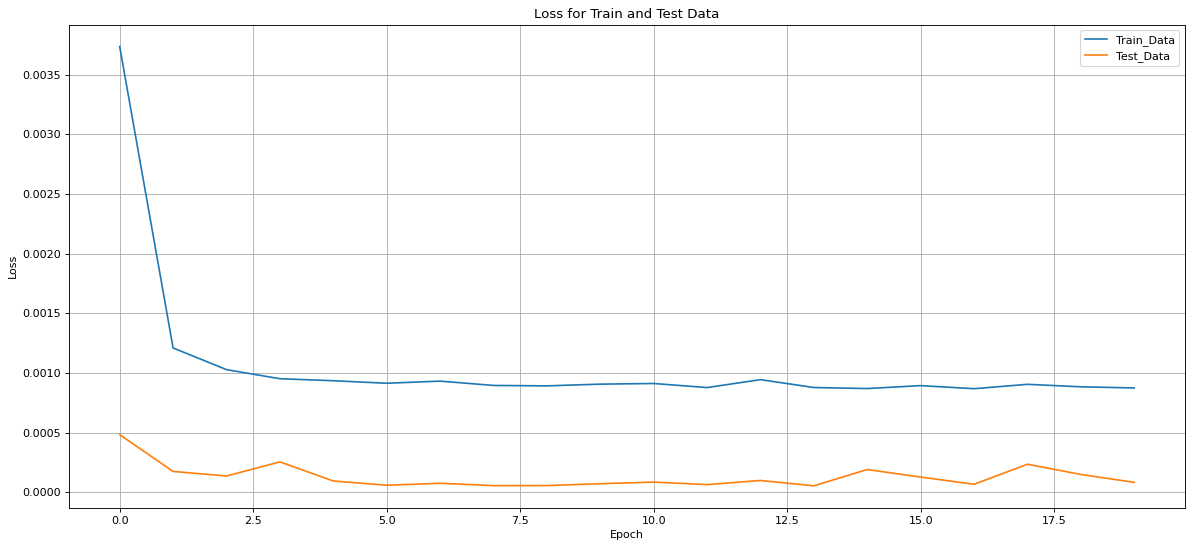

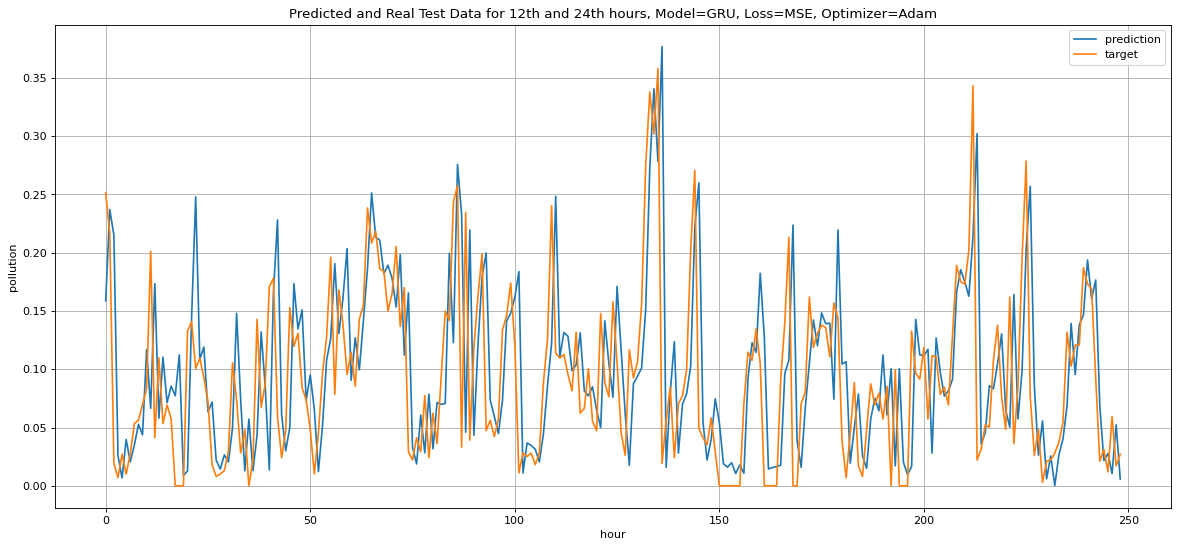

In [ ]:
plot_loss(history, 'Loss for Train and Test Data')
print()
plot_predicted_and_real_values(real, predicted, 'Predicted and Real Test Data for 12th and 24th hours, Model=GRU, Loss=MSE, Optimizer=Adam')

In [ ]:
model.evaluate(test_data_generator, verbose=2)

[8.374439494218677e-05, 0.0005298923933878541, 0.014855287969112396]